In [1]:
# Igor Lipatov
# osh1308@gmail.com
# competition:
# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification
# my configuration:
# CPU: Intel Xeon e5 1650V1
# RAM: 16Gb
# scikit-learn     0.22.1
# daal4py          2020.1
# docker image intelpython/intelpython3_full

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import time
import numpy as np
import sys

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e3ac4e410>]],
      dtype=object)

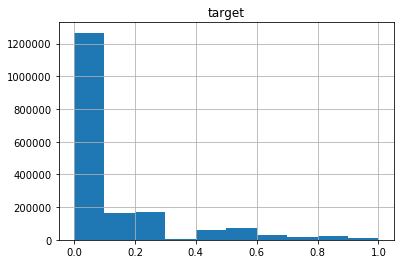

In [3]:
#В данном соревновании необходимо построить модель для оценки токсичности комментария.
#Это можно сделать либо только с помощью основной метки target ∈[0,1],либо дополнительно с применением вспомогательных identety_attack,insult и т.д.
#Я буду использовать только основную метку target.

#Читаем данные при помощи pandas в dataframe.
data = pd.read_csv('./data/train.csv')
data.head()
data.hist(bins=10,column='target')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e3a140290>]],
      dtype=object)

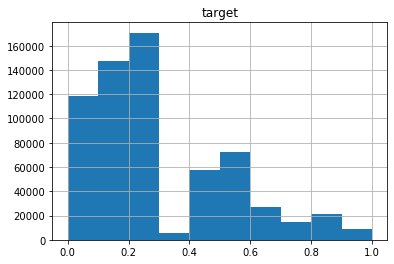

In [4]:
#Датасет слишком несбалансирован,очень много комментариев с меткой <= 0.1.
#Сократим число таких комментариев.
#Выделим комментарии с меткой <= 0.1.
zeros = data[data.target <= 0.1]
#Выделим все остальные комментарии.
nonzeros = data[data.target > 0.1]
#Извлечем подвыборку из комментариев с низким значением метки.
zeros = zeros.sample(n=120000, random_state=42)
#И соберем наш dataframe обратно.
data = pd.concat([zeros,nonzeros])
zeros = None
nonzeros = None
data.hist(bins=10,column='target')
#Датасет отбалансирован,теперь можно приступать к анализу.

In [5]:
#Я буду использовать сочетание векторизации подсчетом и регрессии на деревьях решений.
#Векторизация подсчетом закодирует текст комментария в унитарное представление,где
#1 или 0 на k-й позиции обозначают наличие или отсутствие k-го слова из словаря в комментарии.
#Размер словаря 350 подобран эмпирически.
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,stop_words = None,max_features = 350)
#Обучаем наш векторизатор.
train_data_features = vectorizer.fit_transform(data['comment_text'])
#Раздеим наш датасет на обучающую и тестовую выборки.
train_features, test_features, train_labels, test_labels = train_test_split(train_data_features, data['target'], test_size = 0.25, random_state = 42)

In [6]:
#Функция,запускающая обучение случайного леса.
#Увеличение числа деревьев, равно как и увеличение глубины дерева не приводит к существенному улучшению точности,но заметно увеличивает время обучения.
#Поэтому я оставил 12 и 30 соответсвенно.
def fit(train_features, train_labels):
    rf = RandomForestRegressor(n_estimators = 12, random_state = 42, verbose = 2, n_jobs = -1, max_depth = 30)
    start = time.time()
    rf.fit(train_features, train_labels)
    stop = time.time()
    fit_time = stop - start
    return rf, fit_time

#И функция,считающая ошибку на тестовой выборке.
def evaluate(test_features, test_labels, rf):
    predictions = rf.predict(test_features)
    errors = abs(predictions - test_labels)
    error = round(np.mean(errors), 2)
    return error

In [7]:
#Обучим стандартный RandomForestRegressor из sklearn и посчитаем ошибку на тестовой выборке.
from sklearn.ensemble import RandomForestRegressor
rf, sklearn_fit_time = fit(train_features, train_labels)
sklearn_error = evaluate(test_features, test_labels, rf)
print('sklearn_fit_time: ',sklearn_fit_time)
print('sklearn_error: ',sklearn_error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 12
building tree 2 of 12building tree 3 of 12
building tree 4 of 12
building tree 5 of 12
building tree 6 of 12
building tree 7 of 12
building tree 8 of 12

building tree 9 of 12
building tree 10 of 12
building tree 11 of 12
building tree 12 of 12


[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed: 35.5min remaining: 106.5min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 35.9min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 35.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


sklearn_fit_time:  2154.1552543640137
sklearn_error:  0.17


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.1s finished


In [8]:
#Освободим память.
train_features = None
test_features = None 
train_labels = None
test_labels = None
rf = None
errors = None
predictions = None
error = None

In [9]:
#CountVectorizer возвращает разреженные матрицы,но daal не может их обрабатывать,поэтому преобразуем их в массив.
#Также не забудем,про время преобразования разреженных матриц в массивы.
start = time.time()
train_data_features = train_data_features.toarray()
stop = time.time()
transform_time = stop - start
#Раздеим наш датасет на обучающую и тестовую выборки.
train_features, test_features, train_labels, test_labels = train_test_split(train_data_features, data['target'], test_size = 0.25, random_state = 42)

In [10]:
#Освободим память.
vectorizer = None
train_data_features = None
data = None

In [11]:
#Обучим RandomForestRegressor при помощи daal и посчитаем ошибку на тестовой выборке.
from daal4py.sklearn.ensemble import RandomForestRegressor
rf, daal_fit_time = fit(train_features, train_labels)
#Учтем время преобразования исходных данных.
daal_fit_time += transform_time
daal_error = evaluate(test_features, test_labels, rf)
print('daal_fit_time: ',daal_fit_time)
print('daal_error: ',daal_error)

/opt/conda/lib/python3.7/site-packages/daal4py/sklearn/ensemble/decision_forest.py:322: UserWarning: RandomForestRegressor ignores non-default settings of n_jobs
  warnings.warn(_class_name + ' ignores non-default settings of n_jobs')
/opt/conda/lib/python3.7/site-packages/daal4py/sklearn/ensemble/decision_forest.py:324: UserWarning: RandomForestRegressor ignores non-default settings of verbose
  warnings.warn(_class_name + ' ignores non-default settings of verbose')


daal_fit_time:  374.81509137153625
daal_error:  0.17


In [12]:
#При помощи внешнего профайлера измерим потребление памяти
#python -m memory_profiler 
#Mem usage     Increment    Line Contents
#2005.461 MiB  212.344 MiB  train_data_features = vectorizer.fit_transform(data['comment_text'])
#3559.773 MiB 1554.312 MiB  train_data_features = train_data_features.toarray()
#Потребление памяти при использовании daal возросло примерно в 7.3 раза.
#При этом время обучения уменьшилось примерно в 5.8 раз при той же точности.
print('acceleration: ',sklearn_fit_time / daal_fit_time)

acceleration:  5.747247920251703
